* json how to: https://realpython.com/python-requests/
* USA source: https://covidtracking.com/us-daily/
* world source: https://www.trackcorona.live
* state pop source: https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html#par_textimage_1873399417
* state abbreviation source: https://www.50states.com/abbreviations.htm

# State

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [3]:
state_response = requests.get('https://covidtracking.com/api/states')

if state_response.status_code == 200:
    print('Success!')
else:
    print('An error has occurred')
    exit()


Success!


In [4]:
# Convert json to df
df_state = pd.json_normalize(state_response.json())

In [5]:
# Import states, abbreviations, state population
abbrevs = pd.read_csv('abbrevs.csv')
statepop = pd.read_csv('statepop.csv').iloc[5:].loc[:,('NAME','POPESTIMATE2019')].reset_index(drop = True)
state_pop = abbrevs.merge(statepop, left_on='State', right_on='NAME').loc[:,('NAME','Abbreviation','POPESTIMATE2019')]
state_pop.columns = ['state','abbrev','Pop2019']

In [6]:
class state_tracker:
    '''
    Returns covid stats, sorts by preference, and plots results
    '''
    def __init__(self, df, state_pop=state_pop, states_list=['MA', 'TX', 'OH', 'VT']):
        '''
        Selects appropriate columns and filters by state. Calculates percent deaths and percent hospitalized.
        
        % Deaths = Deaths/Positive
        % Hospitalized = Hospitalized/Positive
        '''
        # Select appropriate columns
        self.df = df[['state','positive','negative','hospitalized','death','lastUpdateEt']]
        # Rename columns
        self.df.columns = ['State', 'Positive', 'Negative', 'Hospitalized', 'Deaths', 'Last Updated']
        # Replace NaN with 0
        self.df = self.df.fillna(0)
        
        self.state_pop = state_pop
        self.merged = self.df.merge(self.state_pop, left_on='State', right_on='abbrev')
        self.merged = self.merged.drop(['state','abbrev'], 1)
        df_select = pd.DataFrame({        
                'State':[], 
                'Positive':[], 
                'Negative':[], 
                'Hospitalized':[], 
                'Deaths':[], 
                '% Deaths':[], 
                '% Hospitalized':[],
                'Last Updated':[],
                'Pop2019':[]
            })
        
        for i in range(0,len(states_list)):
            state = self.merged[self.merged['State']== states_list[i]]
            df_select = df_select.append(state)
        
        # Percent death calculation
        df_select['% Deaths'] = round((df_select['Deaths']/df_select['Positive']) *100,2)
        df_select['% Hospitalized'] = round((df_select['Hospitalized']/df_select['Positive']) *100,2)
        df_select['% Pop Positive'] = round((df_select['Positive']/df_select['Pop2019']) *100,2)
        self.df_select = pd.DataFrame(df_select)
    def all_df(self):
        '''
        Returns all states, select columns only.
        '''
        return self.merged
    
    def plotter(self, sort_by="% Hospitalized"):
        '''
        Plots the formatted df by the sort_by variable.
        '''
        df = self.df_select.sort_values(sort_by, ascending=False)
        sns.barplot(x = df.State, y = df[sort_by])
        plt.title(f"Number of {sort_by} results per State")
        
        return plt.show()
    
    def table(self, sort_by="% Hospitalized"):
        '''
        Returns the formatted df, but in a readable and prettified table
        
        Adds commas at 1000 values
        Adds % to the percent tables
        All values are in string
        '''
        df_select = self.df_select
        df_select = df_select.sort_values(sort_by, ascending = False)

        # Prettify output
        # Format percentages
        df_select['% Deaths'] = df_select['% Deaths'].apply(str) + "%"
        df_select['% Hospitalized'] = df_select['% Hospitalized'].apply(str) + "%"
        df_select['% Pop Positive'] = df_select['% Pop Positive'].apply(str) + "%"

        # Round floats to just integers, use commas to separate
        columns = ['Positive', 'Negative', 'Hospitalized', 'Deaths', 'Pop2019']

        for col in columns:
            df_select[col] = pd.to_numeric(df_select[col]).apply(round)
            df_select[col] = df_select[col].apply(lambda x: "{:,}".format(x))
        self.table = df_select
        return(self.table)


In [7]:
yan = ['MA', 'TX', 'OH', 'VT', 'NY', 'NJ', 'CA']
chat = ['MA', 'TX', 'OH', 'VT']

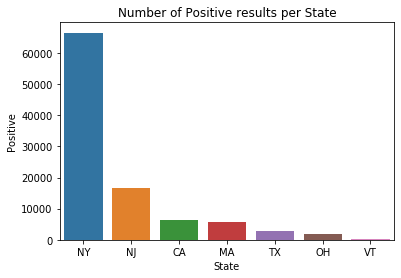

In [8]:
covid = state_tracker(df_state, states_list=yan)
covid.plotter(sort_by="Positive")

In [9]:
covid.table(sort_by = "Pop2019")

,State,Positive,Negative,Hospitalized,Deaths,% Deaths,% Hospitalized,Last Updated,Pop2019,% Pop Positive
4,CA,"6,447","20,549","1,432",133,2.06%,22.21%,3/30 00:00,"39,512,223",0.02%
42,TX,"2,877","33,003",0,34,1.18%,0.0%,3/30 12:45,"28,995,881",0.01%
33,NY,"66,497","119,971","13,721","1,218",1.83%,20.63%,3/29 09:16,"19,453,561",0.34%
34,OH,"1,933","25,342",475,39,2.02%,24.57%,3/30 14:00,"11,689,100",0.02%
30,NJ,"16,636","25,224",0,198,1.19%,0.0%,3/29 13:30,"8,882,190",0.19%
18,MA,"5,752","37,041",453,56,0.97%,7.88%,3/30 16:15,"6,892,503",0.08%
45,VT,256,"3,674",18,12,4.69%,7.03%,3/30 13:00,"623,989",0.04%


In [11]:
all_df = covid.all_df()
all_pos = all_df.sum()["Positive"]
all_dead = all_df.sum()["Deaths"]
all_hosp = all_df.sum()["Hospitalized"]

print("Totals in the USA to date:")
print(f'     Infected: {"{:,}".format(round(all_pos))}')
print(f'     Hospitalized: {"{:,}".format(round(all_hosp))}') 
print(f'     Deaths: {"{:,}".format(round(all_dead))}')

Totals in the USA to date:
     Infected: 159,865
     Hospitalized: 22,284
     Deaths: 2,923


# World

In [ ]:
import time

In [ ]:
world_response = requests.get('https://www.trackcorona.live/api/countries/')

if world_response.status_code == 200:
    print('Success!')
else:
    print('An error has occurred')
    exit()

In [ ]:
# Convert json to df
df_world = pd.json_normalize(world_response.json()['data'])

In [ ]:
country_list = ['United States', 'Hungary', 'Jordan', 'Brazil', 'Cambodia', 'Germany']

In [ ]:
def world_tracker(df, country_list=country_list):
    df = df.set_index("location").loc[country_list, ['confirmed','dead','recovered','updated']]
    df.columns = ["Confirmed", "Dead", "Recovered", "Updated"]
    df = df.sort_values("Confirmed", ascending=False)
    return df

In [ ]:
df = world_tracker(df_world)

In [ ]:
df.head()

In [ ]:
from datetime import datetime
datetime.strptime(df['Updated'][0][:19], "%Y-%m-%d %H:%M:%S")

In [ ]:
help(datetime.strptime)

# Cities

In [ ]:
city_response = requests.get('https://www.trackcorona.live/api/cities/')

if city_response.status_code == 200:
    print('Success!')
else:
    print('An error has occurred')
    exit()

In [ ]:
# Convert json to df
df_city = pd.json_normalize(city_response.json()['data'])

In [ ]:
df_city.set_index("location")